## Inititalize

Run install_libraries notebook first.

General

In [52]:
import pandas as pd
import numpy as np
from dask.distributed import Client
from dask import delayed
import dask.dataframe as dd
import dask, ast, itertools
import dask_ml.model_selection as dcv

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
import datetime as dt
import boto3, yaml
from sagemaker import get_execution_role
from datetime import timedelta

from scipy.stats import expon

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler, label_binarize, MinMaxScaler
#from imblearn.over_sampling import SMOTE
import itertools
from sklearn.metrics import roc_curve, auc, precision_score, f1_score, recall_score, average_precision_score, precision_recall_curve, confusion_matrix, classification_report

import sys,os, joblib
util_path = os.path.abspath(os.path.join(os.path.pardir, '../sasse-polygon-process/lib'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)
    
from util import evaluate, feature_selection, plot_class_hist, read_data, plot_roc, plot_confusion_matrix, prec_rec_curve

from config import read_options
from viz import Viz
from filehandler import FileHandler

sns.set()
sns.set_style("whitegrid")
%matplotlib inline

Following snippet is used to get forest columns from database (inserted into ../cnf/rfc.ini)

In [2]:
print(dask.__version__)
print(pd.__version__)

2.12.0
1.0.3


In [22]:
client = Client('Dask-Scheduler.local-dask:8786')
client.get_versions(check=True)
client

Client Scheduler: tcp://Dask-Scheduler.local-dask:8786 Dashboard: http://Dask-Scheduler.local-dask:8787/status,Cluster Workers: 2 Cores: 4 Memory: 17.18 GB


In [ ]:
client.restart()

In [4]:
#fh = FileHandler() #s3_bucket='fmi-sasse-classification-dataset')
#viz = Viz()

In [4]:
class Options(): pass

options = Options()
options.config_filename = '../cnf/rfc.ini'
options.config_name = 'thin'
read_options(options)

## Functions

Needed to visualise trained models later:

In [5]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          cmap=plt.cm.YlOrBr,
                          filename=None,
                          fontsize=20):
        """
        Normalization can be applied by setting `normalize=True`.
        """
        plt.clf()
        plt.rc('font', size=fontsize)

        fig, ax = plt.subplots(figsize=(6,6))
        np.set_printoptions(precision=2)
        cm = confusion_matrix(y_true, y_pred)
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.grid(False, which='major')
        
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        tick_marks = np.arange(len(classes))
        ax.xaxis.tick_top()
        plt.xticks(tick_marks, classes) #, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        fig.subplots_adjust(bottom=0.12)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

In [6]:
def prec_rec_curve(y, y_pred, n_classes, fontsize=20):
    """
    Precision - Recall Curve
    """
    plt.rc('font', size=fontsize)

    y = label_binarize(y, classes=np.arange(n_classes))

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y[:, i], y_pred[:, i])
        average_precision[i] = average_precision_score(y[:, i], y_pred[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(y.ravel(), y_pred.ravel())
    average_precision["micro"] = average_precision_score(y, y_pred, average="micro")
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))

    plt.figure(figsize=(12, 12))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y_ = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y_ >= 0], y_[y_ >= 0], color='gray', alpha=0.5)
        plt.annotate('F1={0:0.1f}'.format(f_score), xy=(0.9, y_[45] + 0.02))

    lines.append(l)
    labels.append('F1 curves')

    l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
    lines.append(l)
    labels.append('Micro-average (area = {0:0.2f})'
    ''.format(average_precision["micro"]))

    for i in range(n_classes):
        l, = plt.plot(recall[i], precision[i], lw=2)
        lines.append(l)
        labels.append('Class {0} (area = {1:0.2f})'.format(i, average_precision[i]))

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(np.arange(.2, 1., .2))
    plt.xlabel('Recall', labelpad=20)
    plt.ylabel('Precision', labelpad=20)
    plt.title('Precision-Recall Curve', pad=20)
    plt.legend(lines, labels, loc=(0, -.2), ncol=2)

In [117]:
class SVCT(BaseEstimator):
    """
    2-phase SVC for SASSE ERA5 polygon classification
    """
    
    def __init__(self, args1={'kernel': 'rbf', 'probability': True}, args2={'kernel': DotProduct(), 'probability': True}, verbose=False, bayesian_prediction=False):
        """
        ...
        """
        self.model1 = SVC(**args1)
        self.model2 = SVC(**args2)          
        
        self.verbose=verbose
        self.bayesian_prediction = bayesian_prediction
    
    def fit(self, X, y):
        """
        Empty function, logical model doesn't need any training
        """
        
        X1 = X
        y1 = y.copy()
        y1[(y1>0)] = 1

        X2 = X[(y > 0)]
        y2 = y[(y > 0)]

        if self.verbose:
            print('Fitting model 1...')
        self.model1.fit(X1, y1)

        if self.verbose:
            print('Fitting model 2...')            
        self.model2.fit(X2, y2)
        
        return self
        

    def predict(self, X):
        """
        Predict
        """
        
        #y_pred_proba = self.predict_proba(X)
        
        #return np.argmax(y_pred_proba, axis=1)
        
        # Alternative, more straight forward method
        y1_ = self.model1.predict(X)        
        X2_ = X[(y1_>0)]
        y2_ = self.model2.predict(X2_)        
        y1_[(y1_ > 0)] = y2_
        
        return yp1_

    def predict_proba(self, X):
        """
        Predict with probabilities
        """
        
        yp1_ = self.model1.predict_proba(X)
        yp2_ = self.model2.predict_proba(X)

        y_pred_proba = np.zeros((len(X), 3))

        # If use bayesian, predict classes 1 and 2 as bayesian probability, 
        # else pick probablities directly from model outputs
        
        if self.bayesian_prediction:
            y_pred_proba[:,0] = yp1_[:,0]
            y_pred_proba[:,1] = self.bayes(yp1_[:,1], yp2_[:,0], (1-yp1_[_:,0]))
            y_pred_proba[:,2] = self.bayes(yp1_[:,1], yp2_[:,1], (1-yp1_[_:,0]))
        else:
            y_pred_proba[:,0] = yp1_[:,0]
            y_pred_proba[:,1] = np.where(yp1_[:,1] >=.5, yp2_[:,0], yp1_[:,1])
            y_pred_proba[:,2] = np.where(yp1_[:,1] >=.5, yp2_[:,1], yp1_[:,1])
            
        return y_pred_proba    

    def bayes(self, p_a, p_b_given_a, p_b_given_not_a):
        # calculate P(not A)
        not_a = 1 - p_a
        # calculate P(B)
        p_b = p_b_given_a * p_a + p_b_given_not_a * not_a
        # calculate P(A|B)
        p_a_given_b = (p_b_given_a * p_a) / p_b
        return p_a_given_b


## Local dataset random

### Get data

In [75]:
name='loiste_jse_recent_15'
name_random = 'loiste_jse_random_15'
X_train_random, y_train_random, X_test_random, y_test_random = read_data('../data/{}_thin_train.csv'.format(name_random), 
                                                                                             '../data/{}_thin_test.csv'.format(name_random),
                                                                                             options)

X_res_random, y_res_random, _, _ = read_data('../data/{}_all_res.csv'.format(name_random), 
                                             None,
                                             options)

Train data shape: (5132, 35)
Test data shape: (1026, 35)
Train data shape: (14172, 35)


### Train

In [118]:
model = SVCT(verbose=True)
model.fit(X_res_random, y_res_random)

Fitting model 1...
Fitting model 2...


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


SVCT(args1=None, args2=None, verbose=True)

### Predict

In [119]:
y_pred = model.predict(X_test_random)

In [125]:
y_pred_proba = model.predict_proba(X_test_random)
#assert np.allclose(y_pred, np.argmax(y_pred_proba, axis=1))
print(y_pred)
print(np.argmax(y_pred_proba, axis=1))

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


### Evaluate

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       900
           1       0.11      0.16      0.13        64
           2       0.30      0.55      0.39        62

    accuracy                           0.78      1026
   macro avg       0.45      0.52      0.47      1026
weighted avg       0.84      0.78      0.81      1026

Average precision score, micro-averaged over all classes: 0.89


<Figure size 432x288 with 0 Axes>

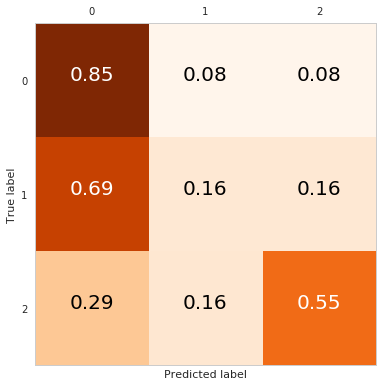

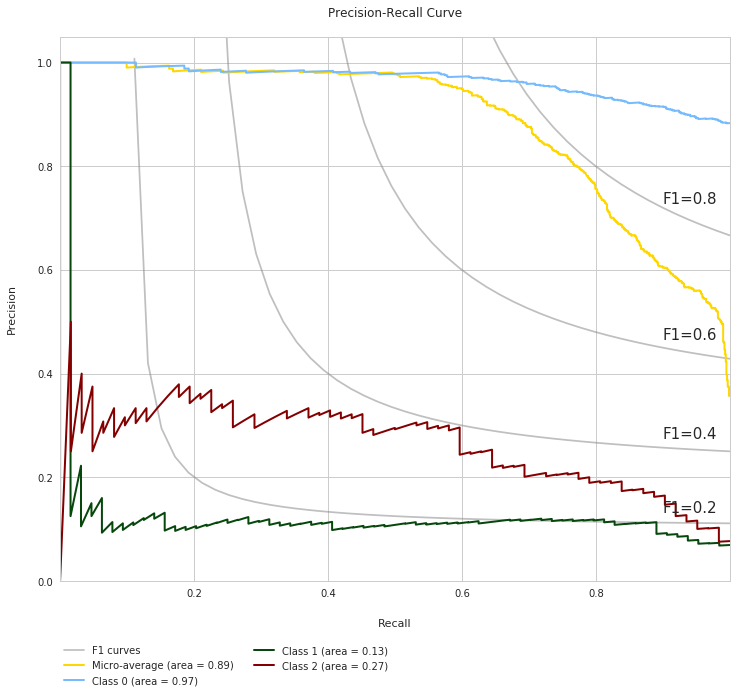

In [116]:
plot_confusion_matrix(y_test_random, y_pred, range(0,3), normalize=True, cmap=plt.cm.Oranges)
prec_rec_curve(y_test_random, model.predict_proba(X_test_random), 3, fontsize=15)
#plot_roc(y_test_random, yp1_, 3, fontsize=15)

## Energiateollisuus

### Get data

In [11]:
X_train_ene, y_train_ene, X_test_ene, y_test_ene = read_data('../data/energiateollisuus_small_train.csv', '../data/energiateollisuus_all_test.csv', options)

Train data shape: (4000, 58)
Test data shape: (28296, 58)


## Train

In [12]:
kernel = PairwiseKernel(metric='laplacian') *  DotProduct()
gpc_ene = GaussianProcessClassifier(kernel=kernel, n_jobs=-1)

with joblib.parallel_backend('dask'):
    gpc_ene.fit(X_train_ene, y_train_ene)

<Figure size 432x288 with 0 Axes>

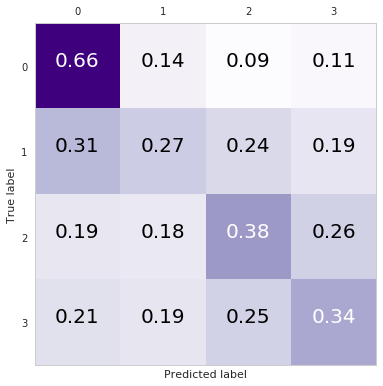

In [13]:
y_pred_proba_ene = gpc_ene.predict_proba(X_test_ene.values)
y_pred_ene = np.argmax(y_pred_proba_ene, axis=1)
plot_confusion_matrix(y_test_ene, y_pred_ene, range(0,4), normalize=True, cmap=plt.cm.Purples)

Average precision score, micro-averaged over all classes: 0.67


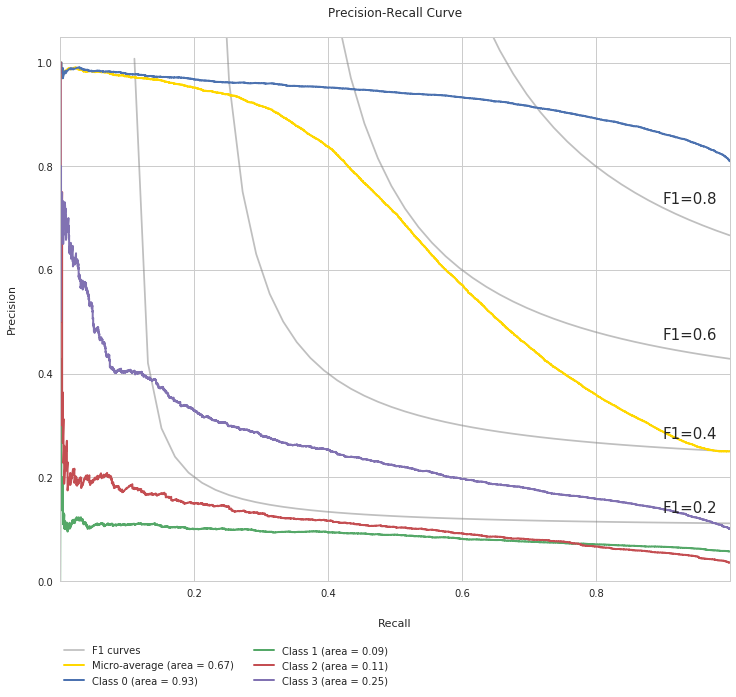

In [14]:
prec_rec_curve(y_test_ene, y_pred_proba_ene, 4, fontsize=15)

In [16]:
print(classification_report(y_test_ene, y_pred_ene))

              precision    recall  f1-score   support

           0       0.92      0.66      0.77     22895
           1       0.10      0.27      0.14      1607
           2       0.10      0.38      0.16       982
           3       0.24      0.34      0.28      2812

    accuracy                           0.60     28296
   macro avg       0.34      0.41      0.34     28296
weighted avg       0.78      0.60      0.66     28296



distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
